In [1]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error

In [6]:
# Load data
df = pd.read_csv('C:/Users/vidis/OneDrive/Desktop/Summer2022/Project Work/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv')

df_prod = df[(df['type'] == 'production') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]
df_cons = df[(df['type'] == 'consumption') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]

# using arima

In [16]:
from statsmodels.tsa.arima_model import ARIMA

Perform stationarity test - https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

p value less than 0.05, evidence of null hypothesis is high, thus stationary time-series

In [29]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_cons['num_kwh'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.958158814823064
2. P-Value :  2.683764428514623e-05
3. Num Of Lags :  48
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 23543
5. Critical Values :
	 1% :  -3.430627790134501
	 5% :  -2.8616627744940484
	 10% :  -2.5668353493315887


In [30]:
model=ARIMA(df_cons['num_kwh'],order=(1,1,1))
history=model.fit()

C:\Users\vidis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\vidis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.num_kwh   No. Observations:                23591
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -39584.949
Method:                       css-mle   S.D. of innovations              1.296
Date:                Wed, 08 Jun 2022   AIC                          79177.898
Time:                        19:08:41   BIC                          79210.173
Sample:                             1   HQIC                         79188.374
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.028e-05      0.001      0.080      0.936      -0.001       0.001
ar.L1.D.num_kwh     0.6052      0.006    101.689      0.000       0.594       0.617
ma.L1.D.num_kwh    -0.9707      0.002   -509.306      0.000      -0.974      -0.967
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6523           +0.0000j            1.6523            0.0000
MA.1            1.0301           +0.0000j            1.0301            0.0000
-----------------------------------------------------------------------------
"""

C:\Users\vidis\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


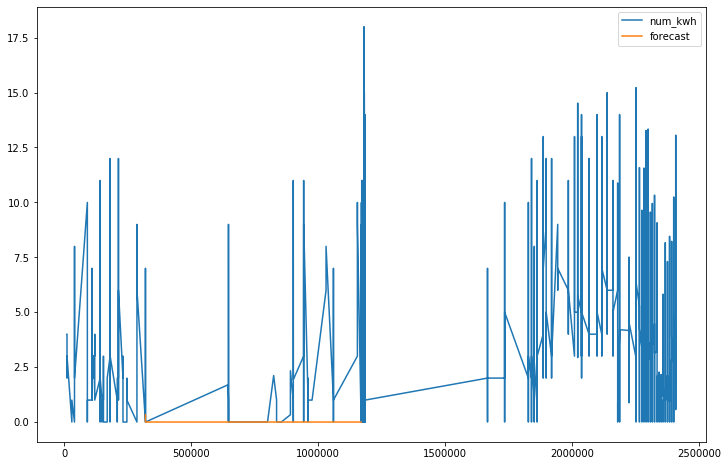

In [36]:
df_cons['forecast']=history.predict(start=1000,end=2000,dynamic=True)
df_cons[['num_kwh','forecast']].plot(figsize=(12,8))

# SARIMAX

In [49]:
!pip install pmdarima 

  Using cached pmdarima-1.8.5-cp37-cp37m-win_amd64.whl (596 kB)


You should consider upgrading via the 'c:\users\vidis\anaconda3\python.exe -m pip install --upgrade pip' command.


In [50]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

In [101]:
# Load data
df = pd.read_csv('C:/Users/vidis/OneDrive/Desktop/Summer2022/Project Work/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv')

df_prod = df[(df['type'] == 'production') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]
df_cons = df[(df['type'] == 'consumption') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]

In [102]:
ts = df_prod[['timeslot','num_kwh']]
#converting 'Date' column to type 'datetime' so that indexing can happen later
ts['timeslot'] = pd.to_datetime(ts['timeslot'])
ts = ts.set_index('timeslot')

C:\Users\vidis\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


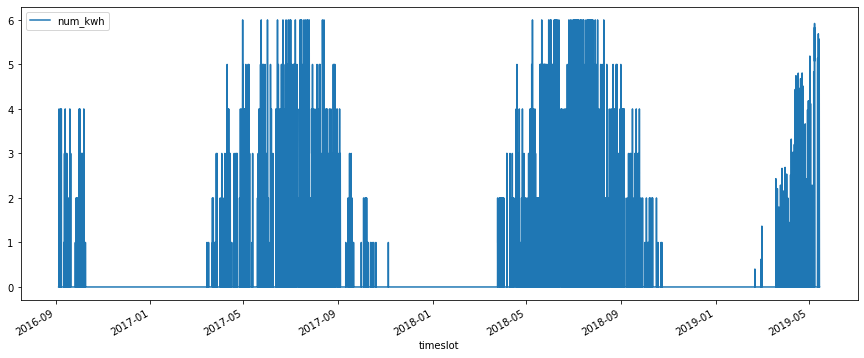

In [103]:
ts.plot(figsize = (15, 6))
plt.show()

assuming annual frequency - lagging of 1 https://otexts.com/fpp2/complexseasonality.html

The Autocorrelation plot for the data is:


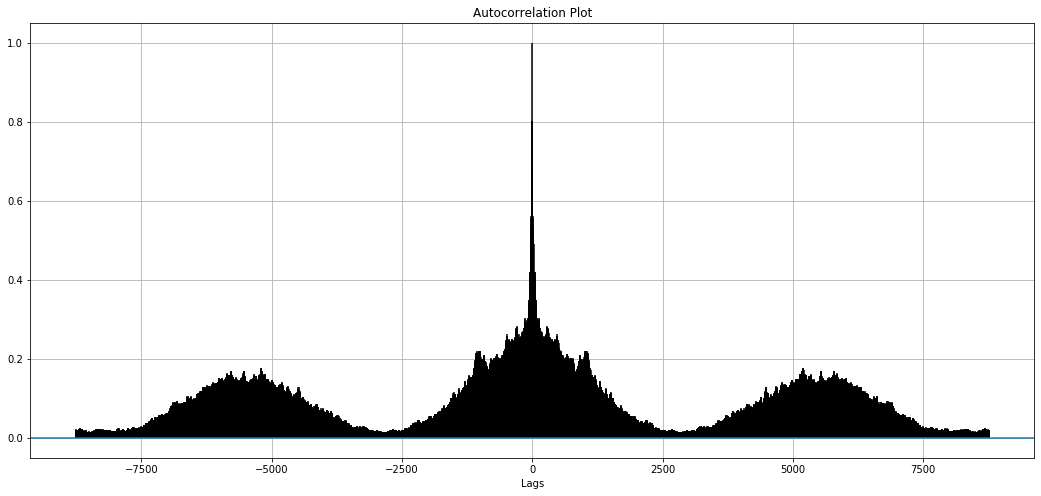

In [104]:
plt.title("Autocorrelation Plot")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(ts['num_kwh'], maxlags = 365*24)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [105]:
print(pm.arima.ndiffs(ts['num_kwh'], alpha=0.05, test='kpss', max_d=2))
print(pm.arima.nsdiffs(ts['num_kwh'], 365*24, max_D=2, test='ocsb'))
adf_test(ts['num_kwh'])

1
0
Results of Dickey-Fuller Test:
Test Statistic                -8.246323e+00
p-value                        5.541598e-13
#Lags Used                     4.700000e+01
Number of Observations Used    2.352000e+04
Critical Value (1%)           -3.430628e+00
Critical Value (5%)           -2.861663e+00
Critical Value (10%)          -2.566835e+00
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   -36.642725
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    23519.000000
Critical Value (1%)               -3.430628
Critical Value (5%)               -2.861663
Critical Value (10%)              -2.566835
dtype: float64
None


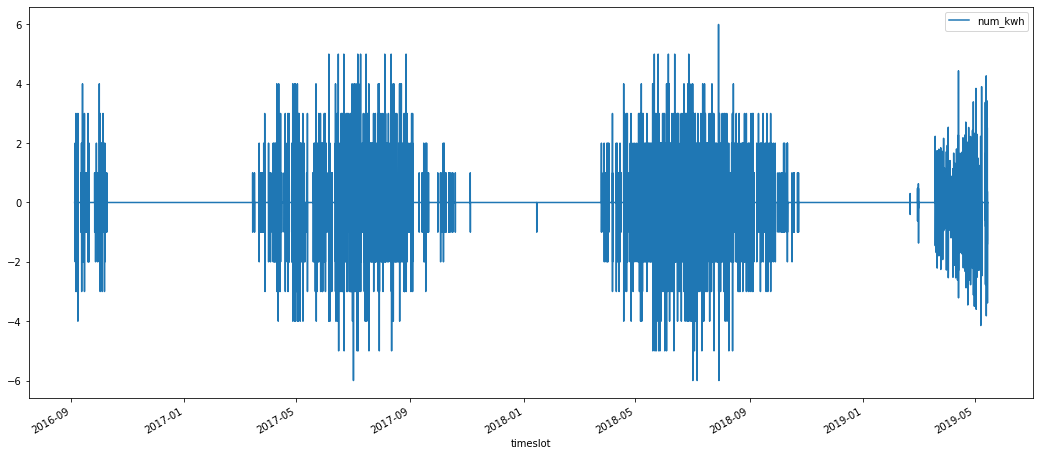

In [106]:
ts_t_adj = ts - ts.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

print(adf_test(ts_t_adj))

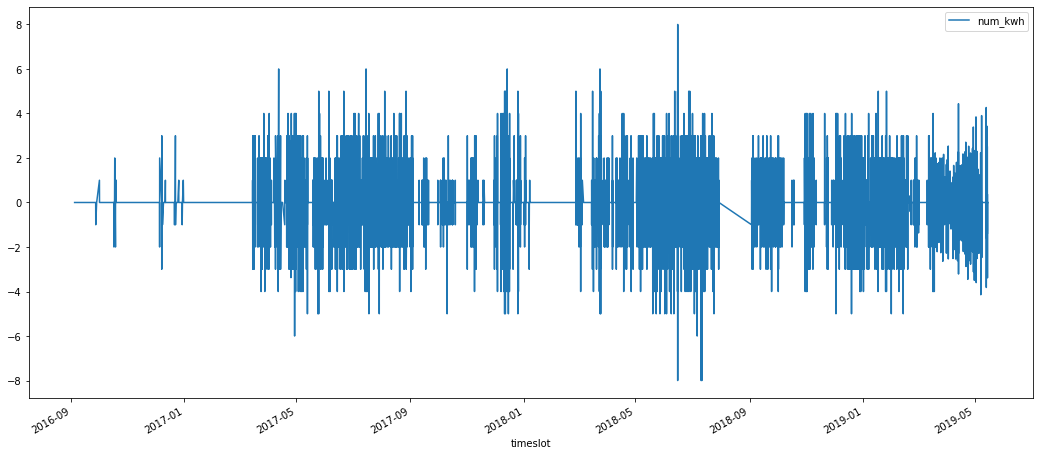

In [107]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(365*24)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

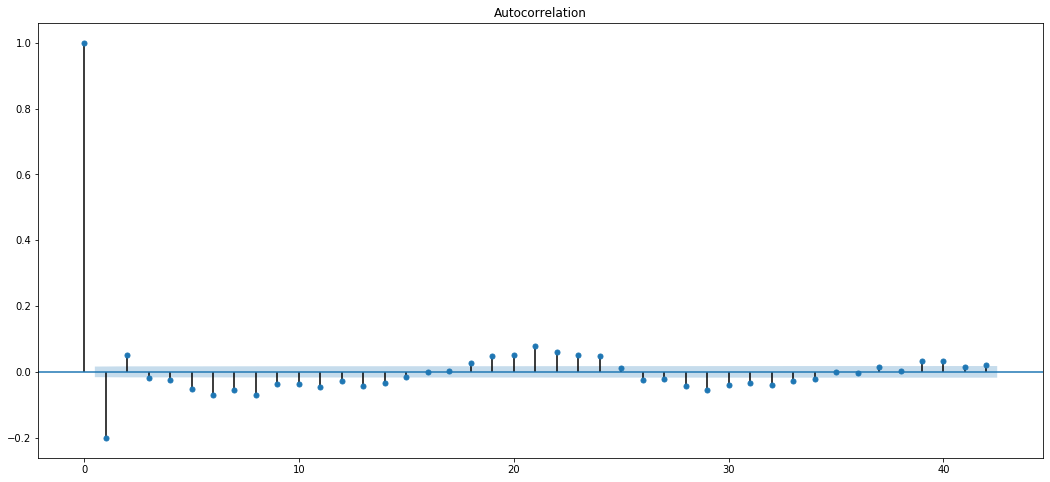

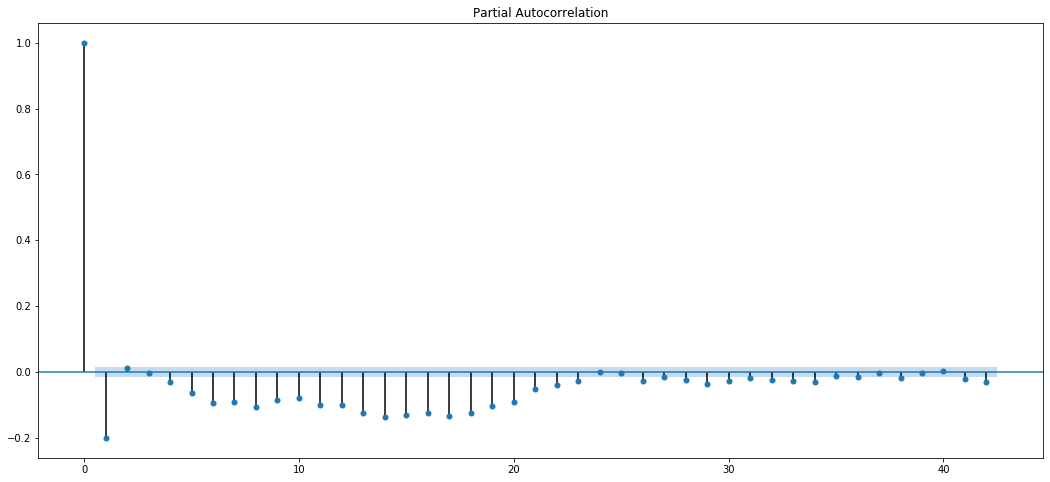

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_s_adj)
plt.show()
plot_pacf(ts_s_adj)
plt.show()

SARIMA (1,1,2) x (1,1,2) _12

In [111]:
p = range(0, 3)
d = range(0,3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365*24) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 8760)
SARIMAX: (0, 0, 1) x (0, 0, 2, 8760)
SARIMAX: (0, 0, 2) x (0, 1, 0, 8760)
SARIMAX: (0, 0, 2) x (0, 1, 1, 8760)


In [ ]:
model = pm.arima.ARIMA([0,0,1], seasonal_order=(0, 0, 1, 8760), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=False, out_of_sample_size=24, scoring='mse', scoring_args=None, trend=None, with_intercept=True)

In [ ]:
print(model.summary())